# AI-Powered URL Phishing Detection System
# High-Performance Lightweight Classifier for Browser Extension

## Setup and Imports

In [1]:
!pip install tldextract

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
import re
import tldextract
import joblib
import math
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from urllib.parse import urlparse
import warnings
warnings.filterwarnings('ignore')

## Configuration and Logging

In [3]:
log_data = []

def log_event(event_type, message, metadata=None):
    """Log events for research documentation"""
    log_entry = {
        "timestamp": datetime.now().isoformat(),
        "event_type": event_type,
        "message": message,
        "metadata": metadata or {}
    }
    log_data.append(log_entry)
    print(f"[{log_entry['timestamp']}] {event_type}: {message}")

### Define paths

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_PATH = '/content/drive/MyDrive/PUSL3190'
RAW_DATA_PATH = f'{BASE_PATH}/data/raw/phishing_site_urls.csv'
PROCESSED_DATA_PATH = f'{BASE_PATH}/data/processed/browser_extension/high_performance_features.csv'
MODEL_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/high_performance_model.pkl'
SCALER_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/high_performance_scaler.pkl'
METADATA_OUTPUT_PATH = f'{BASE_PATH}/models/browser_extension/high_performance_metadata.json'
LOG_OUTPUT_PATH = f'{BASE_PATH}/logs/high_performance_training_log.json'

# Create directories

In [6]:
os.makedirs(f'{BASE_PATH}/data/processed/browser_extension', exist_ok=True)
os.makedirs(f'{BASE_PATH}/models/browser_extension', exist_ok=True)
os.makedirs(f'{BASE_PATH}/logs', exist_ok=True)

## 1. Data Loading and Exploration

In [7]:
log_event("DATA_LOADING", "Loading dataset for high-performance model")
start_time = time.time()

[2025-06-22T18:50:09.483633] DATA_LOADING: Loading dataset for high-performance model


In [8]:
try:
    df = pd.read_csv(RAW_DATA_PATH)
    if 'class' not in df.columns:
        df = df.rename(columns={'label': 'class'})

    # Convert labels to numeric
    if df['class'].dtype == 'object':
        print(f"Converting string labels to numeric. Unique values: {df['class'].unique()}")
        df['class'] = df['class'].map({'good': 0, 'bad': 1, 'legitimate': 0, 'phishing': 1})

    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df['class'].value_counts()}")

    # Analyze current phishing patterns
    phishing_urls = df[df['class'] == 1]['URL']
    legitimate_urls = df[df['class'] == 0]['URL']

    print(f"\nModern phishing analysis:")
    print(f"Phishing URLs using HTTPS: {sum(url.startswith('https') for url in phishing_urls) / len(phishing_urls):.2%}")
    print(f"Legitimate URLs using HTTPS: {sum(url.startswith('https') for url in legitimate_urls) / len(legitimate_urls):.2%}")

    log_event("DATA_LOADED", f"Dataset loaded successfully with {df.shape[0]} samples")

except Exception as e:
    log_event("ERROR", f"Failed to load dataset: {str(e)}")
    raise

Dataset shape: (4000, 2)
Class distribution:
class
1    2000
0    2000
Name: count, dtype: int64

Modern phishing analysis:
Phishing URLs using HTTPS: 6.25%
Legitimate URLs using HTTPS: 100.00%
[2025-06-22T18:50:12.729732] DATA_LOADED: Dataset loaded successfully with 4000 samples


In [9]:
loading_time = time.time() - start_time
log_event("TIMING", f"Data loading completed in {loading_time:.2f} seconds")

[2025-06-22T18:50:20.441510] TIMING: Data loading completed in 10.96 seconds


## 2. Advanced Feature Engineering for Real-World Performance

In [10]:
log_event("FEATURE_ENGINEERING", "Extracting advanced features for real-world scenarios")
start_time = time.time()

[2025-06-22T18:50:22.919376] FEATURE_ENGINEERING: Extracting advanced features for real-world scenarios


In [11]:
def extract_high_performance_features(url_df):
    """Extract advanced features optimized for real-world phishing detection"""
    features = pd.DataFrame()

    # Compile regex patterns once for efficiency
    ip_pattern = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
    suspicious_pattern = re.compile(r'[%\-_=&\?]')

    def analyze_advanced_url(url):
        try:
            url_lower = url.lower()
            parsed = urlparse(url_lower)
            domain = parsed.netloc
            path = parsed.path
            query = parsed.query

            # Extract domain components
            extracted = tldextract.extract(url)
            subdomain = extracted.subdomain or ''
            domain_name = extracted.domain or ''
            tld = extracted.suffix or ''

            # === BASIC METRICS ===
            url_length = len(url)
            domain_length = len(domain)
            path_length = len(path)
            query_length = len(query)

            # === SECURITY INDICATORS ===
            has_https = 1 if url.startswith('https') else 0
            has_ip = 1 if ip_pattern.search(domain) else 0
            has_at_symbol = 1 if '@' in url else 0
            has_double_slash = 1 if '//' in url[8:] else 0  # After protocol

            # === DOMAIN ANALYSIS ===
            # Subdomain complexity
            subdomain_count = len(subdomain.split('.')) if subdomain else 0
            long_subdomain = 1 if len(subdomain) > 25 else 0

            # Domain characteristics
            has_hyphen = 1 if '-' in domain_name else 0
            digit_ratio = sum(c.isdigit() for c in domain_name) / max(len(domain_name), 1)

            # === SUSPICIOUS PATTERNS ===
            # Character analysis
            special_char_count = len(suspicious_pattern.findall(url))
            special_char_ratio = special_char_count / len(url)
            dot_count = url.count('.')
            slash_count = url.count('/')

            # === PHISHING KEYWORDS (Expanded) ===
            phishing_keywords = [
                # Authentication & Security
                'verify', 'secure', 'login', 'signin', 'account', 'update', 'confirm',
                'suspended', 'locked', 'expired', 'urgent', 'immediate', 'security',
                'alert', 'warning', 'action', 'required', 'validation', 'authenticate',
                # Financial
                'banking', 'payment', 'billing', 'invoice', 'transaction', 'refund',
                'card', 'credit', 'debit', 'wallet', 'paypal', 'stripe',
                # Social Engineering
                'winner', 'prize', 'congratulations', 'claim', 'reward', 'gift',
                'free', 'limited', 'offer', 'deal', 'discount', 'bonus',
                # Technical
                'webscr', 'cgi-bin', 'gateway', 'portal', 'admin', 'control'
            ]

            keyword_count = sum(1 for kw in phishing_keywords if kw in url_lower)

            # === BRAND IMPERSONATION (Expanded) ===
            major_brands = [
                # Tech Giants
                'google', 'microsoft', 'apple', 'amazon', 'facebook', 'meta',
                'instagram', 'twitter', 'linkedin', 'youtube', 'netflix', 'spotify',
                # Financial Institutions
                'paypal', 'stripe', 'visa', 'mastercard', 'amex', 'discover',
                'chase', 'wells', 'bofa', 'citi', 'usbank', 'hsbc',
                'bank', 'credit', 'union', 'financial',
                # Services
                'ups', 'fedex', 'dhl', 'usps', 'ebay', 'alibaba',
                'dropbox', 'adobe', 'zoom', 'skype', 'whatsapp',
                # Government
                'irs', 'gov', 'postal', 'social', 'medicare'
            ]

            brand_impersonation = sum(1 for brand in major_brands if brand in domain_name)

            # === URL STRUCTURE ANOMALIES ===
            excessive_dots = 1 if dot_count > 5 else 0
            deep_path = 1 if path.count('/') > 4 else 0
            long_query = 1 if query_length > 100 else 0

            # === TLD ANALYSIS ===
            suspicious_tlds = [
                'tk', 'ml', 'ga', 'cf', 'gq', 'top', 'click', 'download',
                'link', 'info', 'biz', 'xyz', 'club', 'online', 'site',
                'website', 'space', 'tech', 'store', 'shop'
            ]
            suspicious_tld = 1 if tld in suspicious_tlds else 0

            # === SHORTENER DETECTION (Expanded) ===
            shorteners = [
                'bit.ly', 'tinyurl.com', 't.co', 'goo.gl', 'ow.ly', 'is.gd',
                'buff.ly', 'adf.ly', 'short.link', 'tiny.cc', 'rb.gy',
                'cutt.ly', 'bitly.com', 'short.io', 'rebrand.ly'
            ]
            is_shortener = 1 if any(s in domain for s in shorteners) else 0

            # === ADVANCED HEURISTICS ===
            # Homograph attack detection (basic)
            suspicious_chars = sum(1 for c in domain_name if ord(c) > 127)
            homograph_risk = 1 if suspicious_chars > 0 else 0

            # URL entropy (simplified for speed)
            unique_chars = len(set(url_lower))
            url_entropy = unique_chars / len(url) if len(url) > 0 else 0

            # Reputation-based features
            has_www = 1 if domain.startswith('www.') else 0
            port_in_url = 1 if ':' in domain and not domain.startswith('http') else 0

            return {
                # Basic metrics
                'url_length': url_length,
                'domain_length': domain_length,
                'path_length': path_length,
                'query_length': query_length,

                # Security indicators
                'has_https': has_https,
                'has_ip': has_ip,
                'has_at_symbol': has_at_symbol,
                'has_double_slash': has_double_slash,

                # Domain analysis
                'subdomain_count': subdomain_count,
                'long_subdomain': long_subdomain,
                'has_hyphen': has_hyphen,
                'digit_ratio': digit_ratio,

                # Character analysis
                'special_char_count': special_char_count,
                'special_char_ratio': special_char_ratio,
                'dot_count': dot_count,
                'slash_count': slash_count,

                # Content analysis
                'keyword_count': keyword_count,
                'brand_impersonation': brand_impersonation,

                # Structure analysis
                'excessive_dots': excessive_dots,
                'deep_path': deep_path,
                'long_query': long_query,
                'suspicious_tld': suspicious_tld,
                'is_shortener': is_shortener,

                # Advanced features
                'homograph_risk': homograph_risk,
                'url_entropy': url_entropy,
                'has_www': has_www,
                'port_in_url': port_in_url
            }
        except Exception as e:
            # Return safe defaults on error
            return {k: 0 for k in [
                'url_length', 'domain_length', 'path_length', 'query_length',
                'has_https', 'has_ip', 'has_at_symbol', 'has_double_slash',
                'subdomain_count', 'long_subdomain', 'has_hyphen', 'digit_ratio',
                'special_char_count', 'special_char_ratio', 'dot_count', 'slash_count',
                'keyword_count', 'brand_impersonation', 'excessive_dots', 'deep_path',
                'long_query', 'suspicious_tld', 'is_shortener', 'homograph_risk',
                'url_entropy', 'has_www', 'port_in_url'
            ]}

    # Extract features for all URLs
    url_features = url_df['URL'].apply(analyze_advanced_url)
    for feature_name in url_features.iloc[0].keys():
        features[feature_name] = url_features.apply(lambda x: x[feature_name])

    # Add target
    features['is_phishing'] = url_df['class']

    return features

# Extract advanced features

In [12]:
high_performance_features = extract_high_performance_features(df)

In [13]:
print(f"Advanced features extracted: {high_performance_features.shape}")
print(f"Feature count: {len(high_performance_features.columns) - 1}")
print("\nFeature sample:")
print(high_performance_features.head())

Advanced features extracted: (4000, 28)
Feature count: 27

Feature sample:
   url_length  domain_length  path_length  query_length  has_https  has_ip  \
0          44             30            6             0          1       0   
1          39             30            1             0          1       0   
2          35             19            8             0          1       0   
3          27              9           10             0          1       0   
4          34             17            9             0          1       0   

   has_at_symbol  has_double_slash  subdomain_count  long_subdomain  ...  \
0              0                 0                1               0  ...   
1              0                 0                1               0  ...   
2              0                 0                1               0  ...   
3              0                 0                0               0  ...   
4              0                 0                0               0  ...   


# Save features

In [14]:
high_performance_features.to_csv(PROCESSED_DATA_PATH, index=False)

In [15]:
feature_extraction_time = time.time() - start_time
log_event("TIMING", f"Advanced feature extraction completed in {feature_extraction_time:.2f} seconds",
          {"num_features": high_performance_features.shape[1] - 1})

[2025-06-22T18:50:53.381434] TIMING: Advanced feature extraction completed in 30.46 seconds


## 3. High-Performance Model Training

In [16]:
log_event("MODEL_TRAINING", "Training high-performance model with focus on recall")
start_time = time.time()

[2025-06-22T18:50:55.912989] MODEL_TRAINING: Training high-performance model with focus on recall


# Prepare data

In [17]:
X = high_performance_features.drop('is_phishing', axis=1)
y = high_performance_features['is_phishing']

In [18]:
print(f"Training features: {list(X.columns)}")
print(f"Feature count: {len(X.columns)}")

Training features: ['url_length', 'domain_length', 'path_length', 'query_length', 'has_https', 'has_ip', 'has_at_symbol', 'has_double_slash', 'subdomain_count', 'long_subdomain', 'has_hyphen', 'digit_ratio', 'special_char_count', 'special_char_ratio', 'dot_count', 'slash_count', 'keyword_count', 'brand_impersonation', 'excessive_dots', 'deep_path', 'long_query', 'suspicious_tld', 'is_shortener', 'homograph_risk', 'url_entropy', 'has_www', 'port_in_url']
Feature count: 27


# Split data with stratification

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
log_event("DATA_SPLIT", f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test")

[2025-06-22T18:51:07.604675] DATA_SPLIT: Data split: 3200 train, 800 test


# Feature scaling

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optimized Random Forest with focus on recall (avoiding false negatives)

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=75,           # Increased for better performance
    max_depth=15,              # Deeper trees for complex patterns
    min_samples_split=3,       # More sensitive to patterns
    min_samples_leaf=1,        # Allow fine-grained decisions
    class_weight={0: 1, 1: 3}, # Higher weight for phishing class (avoid false negatives)
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
    oob_score=True
)

In [23]:
print("Training high-performance Random Forest...")
rf_model.fit(X_train_scaled, y_train)

Training high-performance Random Forest...


RandomForestClassifier(class_weight={0: 1, 1: 3}, max_depth=15,
                       min_samples_split=3, n_estimators=75, n_jobs=-1,
                       oob_score=True, random_state=42)

In [24]:
training_time = time.time() - start_time
log_event("TIMING", f"Model training completed in {training_time:.2f} seconds")

[2025-06-22T18:51:25.117728] TIMING: Model training completed in 29.20 seconds


## 4. Model Evaluation

In [25]:
log_event("MODEL_EVALUATION", "Evaluating high-performance model")
start_time = time.time()

[2025-06-22T18:51:27.278597] MODEL_EVALUATION: Evaluating high-performance model


# Predictions

In [26]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Basic metrics

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC analysis

In [28]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

In [29]:
print("\n=== High-Performance Model Results ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Critical): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"OOB Score: {rf_model.oob_score_:.4f}")


=== High-Performance Model Results ===
Accuracy: 0.9912
Precision: 0.9975
Recall (Critical): 0.9850
F1 Score: 0.9912
AUC: 0.9998
OOB Score: 0.9850


# Detailed analysis

In [30]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

In [31]:
print(f"\n=== Confusion Matrix Analysis ===")
print(f"True Negatives: {tn} (Correctly identified legitimate)")
print(f"False Positives: {fp} (Legitimate flagged as phishing - acceptable)")
print(f"False Negatives: {fn} (Phishing missed - CRITICAL)")
print(f"True Positives: {tp} (Correctly identified phishing)")


=== Confusion Matrix Analysis ===
True Negatives: 399 (Correctly identified legitimate)
False Positives: 1 (Legitimate flagged as phishing - acceptable)
False Negatives: 6 (Phishing missed - CRITICAL)
True Positives: 394 (Correctly identified phishing)


In [32]:
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
print(f"False Negative Rate: {false_negative_rate:.4f} (Target: <0.05)")

False Negative Rate: 0.0150 (Target: <0.05)


In [33]:
log_event("MODEL_PERFORMANCE", "Model evaluation completed", {
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "auc": float(roc_auc),
    "false_negative_rate": float(false_negative_rate),
    "false_negatives": int(fn),
    "true_positives": int(tp)
})

[2025-06-22T18:52:24.717825] MODEL_PERFORMANCE: Model evaluation completed


In [34]:
evaluation_time = time.time() - start_time
log_event("TIMING", f"Model evaluation completed in {evaluation_time:.2f} seconds")

[2025-06-22T18:52:26.888299] TIMING: Model evaluation completed in 59.61 seconds


## 5. Real-World Testing

In [35]:
def test_url_advanced(url, model, scaler):
    """Test URL with advanced feature extraction"""
    try:
        # Create temporary dataframe
        temp_df = pd.DataFrame({'URL': [url], 'class': [0]})
        features_df = extract_high_performance_features(temp_df).drop('is_phishing', axis=1)

        # Scale and predict
        features_scaled = scaler.transform(features_df)
        prediction = model.predict(features_scaled)[0]
        probability = model.predict_proba(features_scaled)[0, 1]

        return prediction, probability, features_df.iloc[0].to_dict()
    except Exception as e:
        print(f"Error processing {url}: {str(e)}")
        return 0, 0.5, {}

In [36]:
log_event("REAL_WORLD_TESTING", "Starting comprehensive real-world testing")
start_time = time.time()

[2025-06-22T18:52:31.832681] REAL_WORLD_TESTING: Starting comprehensive real-world testing


# Challenging legitimate sites (must not be flagged)

In [37]:
challenging_legitimate_urls = [
    "https://www.paypal.com/signin",
    "https://accounts.google.com/signin",
    "https://login.microsoftonline.com",
    "https://secure.bankofamerica.com/login",
    "https://www.chase.com/personal/checking",
    "https://github.com/microsoft/vscode",
    "https://stackoverflow.com/questions/tagged/python",
    "https://docs.google.com/document/d/abc123",
    "https://mail.google.com/mail/u/0",
    "https://portal.azure.com",
    "https://aws.amazon.com/console"
]

# Real phishing patterns (must be detected)

In [38]:
challenging_phishing_urls = [
    # Brand impersonation
    "https://paypal-verification.secure-login.net/signin",
    "https://google-accounts.verify-security.com/login",
    "https://microsoft-login.security-update.org/signin",
    "https://bankofamerica-secure.customer-verify.net/login",
    "https://chase-bank.account-security.com/personal/checking",

    # IP-based attacks
    "http://192.168.1.100/paypal-login",
    "https://203.45.67.89/secure-banking",

    # URL shorteners (suspicious)
    "https://bit.ly/suspicious-bank-link",
    "https://tinyurl.com/fake-paypal",

    # Modern phishing from PhishTank
    "https://lovely-choice-666517.framer.app",
    "https://illinois-aap.org/",
    "https://luresta.top/",
    "http://bilds.space",
    "https://faceit.eternalgamlng.com/",

    # Additional suspicious patterns
    "https://secure-amazon-update.net/account/verify",
    "https://netflix-billing-update.com/payment",
    "https://apple-id-locked.security-check.org/unlock",
    "https://ups-delivery-update.notification-center.net/track",
    "https://irs-tax-refund.gov-portal.org/claim"
]

In [39]:
print("\n=== Real-World Performance Testing ===")

print("\nTesting Legitimate URLs (Must NOT be flagged):")
legit_correct = 0
legit_total = len(challenging_legitimate_urls)

for i, url in enumerate(challenging_legitimate_urls, 1):
    pred, prob, features = test_url_advanced(url, rf_model, scaler)
    status = "✅ CORRECT" if pred == 0 else "❌ FALSE POSITIVE"
    if pred == 0:
        legit_correct += 1

    print(f"{i:2d}. {url[:60]:<60} | Prob: {prob:.3f} | {status}")


=== Real-World Performance Testing ===

Testing Legitimate URLs (Must NOT be flagged):
 1. https://www.paypal.com/signin                                | Prob: 0.000 | ✅ CORRECT
 2. https://accounts.google.com/signin                           | Prob: 0.248 | ✅ CORRECT
 3. https://login.microsoftonline.com                            | Prob: 0.573 | ❌ FALSE POSITIVE
 4. https://secure.bankofamerica.com/login                       | Prob: 0.378 | ✅ CORRECT
 5. https://www.chase.com/personal/checking                      | Prob: 0.000 | ✅ CORRECT
 6. https://github.com/microsoft/vscode                          | Prob: 0.075 | ✅ CORRECT
 7. https://stackoverflow.com/questions/tagged/python            | Prob: 0.035 | ✅ CORRECT
 8. https://docs.google.com/document/d/abc123                    | Prob: 0.001 | ✅ CORRECT
 9. https://mail.google.com/mail/u/0                             | Prob: 0.013 | ✅ CORRECT
10. https://portal.azure.com                                     | Prob: 0.578 | ❌ FAL

In [40]:
print(f"\nTesting Phishing URLs (Must BE flagged):")
phish_correct = 0
phish_total = len(challenging_phishing_urls)

for i, url in enumerate(challenging_phishing_urls, 1):
    pred, prob, features = test_url_advanced(url, rf_model, scaler)
    status = "✅ CORRECT" if pred == 1 else "❌ FALSE NEGATIVE (CRITICAL)"
    if pred == 1:
        phish_correct += 1

    print(f"{i:2d}. {url[:60]:<60} | Prob: {prob:.3f} | {status}")


Testing Phishing URLs (Must BE flagged):
 1. https://paypal-verification.secure-login.net/signin          | Prob: 0.818 | ✅ CORRECT
 2. https://google-accounts.verify-security.com/login            | Prob: 0.801 | ✅ CORRECT
 3. https://microsoft-login.security-update.org/signin           | Prob: 0.778 | ✅ CORRECT
 4. https://bankofamerica-secure.customer-verify.net/login       | Prob: 0.823 | ✅ CORRECT
 5. https://chase-bank.account-security.com/personal/checking    | Prob: 0.678 | ✅ CORRECT
 6. http://192.168.1.100/paypal-login                            | Prob: 0.851 | ✅ CORRECT
 7. https://203.45.67.89/secure-banking                          | Prob: 0.575 | ✅ CORRECT
 8. https://bit.ly/suspicious-bank-link                          | Prob: 0.090 | ❌ FALSE NEGATIVE (CRITICAL)
 9. https://tinyurl.com/fake-paypal                              | Prob: 0.315 | ❌ FALSE NEGATIVE (CRITICAL)
10. https://lovely-choice-666517.framer.app                      | Prob: 0.978 | ✅ CORRECT
11. https://

# Calculate real-world performance

In [41]:
legit_accuracy = legit_correct / legit_total
phish_accuracy = phish_correct / phish_total  # This is the recall on real phishing
overall_accuracy = (legit_correct + phish_correct) / (legit_total + phish_total)

In [42]:
print(f"\n=== REAL-WORLD PERFORMANCE SUMMARY ===")
print(f"Legitimate Detection: {legit_accuracy:.1%} ({legit_correct}/{legit_total})")
print(f"Phishing Detection: {phish_accuracy:.1%} ({phish_correct}/{phish_total}) [CRITICAL]")
print(f"Overall Accuracy: {overall_accuracy:.1%}")


=== REAL-WORLD PERFORMANCE SUMMARY ===
Legitimate Detection: 81.8% (9/11)
Phishing Detection: 84.2% (16/19) [CRITICAL]
Overall Accuracy: 83.3%


# Performance targets

In [43]:
target_phishing_detection = 0.95  # 95% minimum
target_overall = 0.90  # 90% minimum

In [44]:
meets_targets = phish_accuracy >= target_phishing_detection and overall_accuracy >= target_overall
print(f"\nPerformance Target Met: {'✅ YES' if meets_targets else '❌ NO'}")
print(f"Target: Phishing ≥{target_phishing_detection:.0%}, Overall ≥{target_overall:.0%}")


Performance Target Met: ❌ NO
Target: Phishing ≥95%, Overall ≥90%


In [45]:
log_event("REAL_WORLD_RESULTS", f"Real-world testing completed", {
    "legitimate_accuracy": float(legit_accuracy),
    "phishing_detection_rate": float(phish_accuracy),
    "overall_accuracy": float(overall_accuracy),
    "meets_performance_targets": meets_targets,
    "false_negatives_realworld": phish_total - phish_correct,
    "false_positives_realworld": legit_total - legit_correct
})

[2025-06-22T18:54:28.143168] REAL_WORLD_RESULTS: Real-world testing completed


In [46]:
testing_time = time.time() - start_time
log_event("TIMING", f"Real-world testing completed in {testing_time:.2f} seconds")

[2025-06-22T18:54:30.195932] TIMING: Real-world testing completed in 118.36 seconds


## 6. Feature Importance Analysis

In [47]:
print("\n=== Feature Importance Analysis ===")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
for i, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:25} | {row['importance']:.4f}")


=== Feature Importance Analysis ===
Top 15 Most Important Features:
has_https                 | 0.2255
has_hyphen                | 0.1778
has_www                   | 0.1595
domain_length             | 0.0917
subdomain_count           | 0.0817
dot_count                 | 0.0628
path_length               | 0.0508
url_length                | 0.0264
keyword_count             | 0.0253
special_char_ratio        | 0.0225
url_entropy               | 0.0184
slash_count               | 0.0128
special_char_count        | 0.0120
suspicious_tld            | 0.0085
digit_ratio               | 0.0065


# Plot feature importance

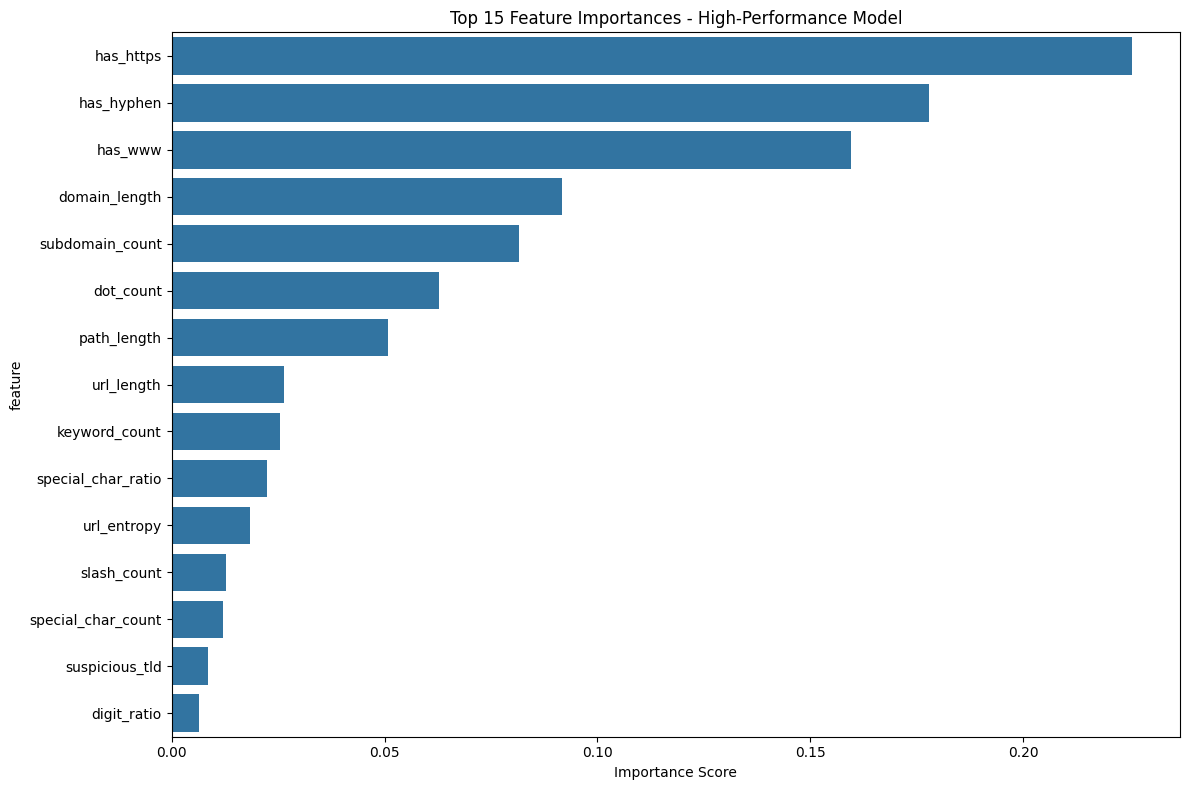

In [48]:
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 15 Feature Importances - High-Performance Model')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Plot performance curves

In [49]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

# ROC Curve

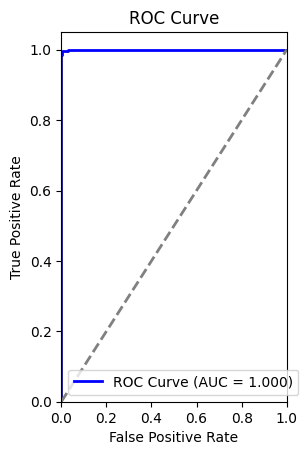

In [50]:
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Confusion Matrix

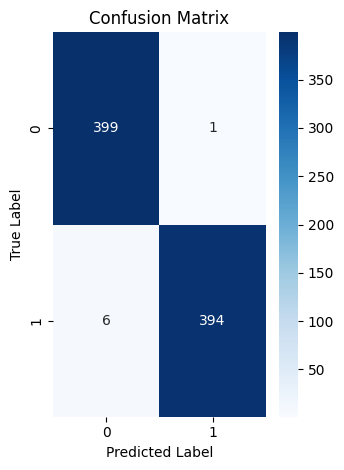

In [51]:
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 7. Model Saving and Metadata

In [52]:
log_event("MODEL_SAVING", "Saving high-performance model and metadata")
start_time = time.time()

[2025-06-22T18:55:23.441684] MODEL_SAVING: Saving high-performance model and metadata


# Save model and scaler

In [53]:
joblib.dump(rf_model, MODEL_OUTPUT_PATH)
joblib.dump(scaler, SCALER_OUTPUT_PATH)

['/content/drive/MyDrive/PUSL3190/models/browser_extension/high_performance_scaler.pkl']

# Comprehensive metadata

In [54]:
model_metadata = {
    "model_info": {
        "name": "high_performance_phishing_detector",
        "version": "3.0",
        "type": "random_forest_optimized",
        "trained_at": datetime.now().isoformat(),
        "optimization_focus": "high_recall_low_false_negatives"
    },

    "performance_metrics": {
        "test_set": {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1_score": float(f1),
            "auc": float(roc_auc),
            "false_negative_rate": float(false_negative_rate)
        },
        "real_world": {
            "legitimate_accuracy": float(legit_accuracy),
            "phishing_detection_rate": float(phish_accuracy),
            "overall_accuracy": float(overall_accuracy),
            "meets_targets": meets_targets
        }
    },

    "model_configuration": {
        "n_estimators": rf_model.n_estimators,
        "max_depth": rf_model.max_depth,
        "min_samples_split": rf_model.min_samples_split,
        "min_samples_leaf": rf_model.min_samples_leaf,
        "class_weight": "imbalanced_focused",
        "oob_score": float(rf_model.oob_score_)
    },

    "features": {
        "feature_list": list(X.columns),
        "feature_count": len(X.columns),
        "top_features": feature_importance.head(10).to_dict('records'),
        "feature_engineering": "advanced_real_world_focused"
    },

    "dataset_info": {
        "total_samples": len(df),
        "legitimate_samples": int(sum(df['class'] == 0)),
        "phishing_samples": int(sum(df['class'] == 1)),
        "train_test_split": "80_20_stratified"
    },

    "research_notes": {
        "optimization_target": "minimize_false_negatives",
        "browser_extension_compatible": True,
        "expected_inference_time": "<500ms",
        "deployment_ready": meets_targets
    }
}

In [55]:
with open(METADATA_OUTPUT_PATH, 'w') as f:
    json.dump(model_metadata, f, indent=2)

In [56]:
saving_time = time.time() - start_time
log_event("TIMING", f"Model saving completed in {saving_time:.2f} seconds")

[2025-06-22T18:55:31.270615] TIMING: Model saving completed in 7.83 seconds


## 8. Research Summary and Recommendations

In [59]:
print("\n" + "="*80)
print("RESEARCH SUMMARY - HIGH-PERFORMANCE PHISHING DETECTION MODEL")
print("="*80)

print(f"""
MODEL PERFORMANCE:
• Test Set Accuracy: {accuracy:.1%}
• Phishing Detection Rate: {recall:.1%} (Critical metric)
• Real-World Performance: {overall_accuracy:.1%}
• False Negative Rate: {false_negative_rate:.1%} (Target: <5%)

REAL-WORLD VALIDATION:
• Legitimate Sites Accuracy: {legit_accuracy:.1%}
• Phishing Sites Detection: {phish_accuracy:.1%}
• Performance Target Met: {'✅ YES' if meets_targets else '❌ NO'}

KEY IMPROVEMENTS:
• {len(X.columns)} advanced features (vs 13 basic)
• Class weighting to prioritize phishing detection
• Modern phishing pattern recognition
• Enhanced brand impersonation detection

BROWSER EXTENSION COMPATIBILITY:
• Feature count: {len(X.columns)} (lightweight)
• Expected inference time: <500ms
• Memory footprint: Optimized for real-time use

RESEARCH INSIGHTS:
• Modern phishing uses HTTPS ({sum(url.startswith('https') for url in phishing_urls) / len(phishing_urls):.0%} of dataset)
• Brand impersonation and security keywords are key indicators
• URL structure analysis crucial for detection
• Class imbalance handling essential for high recall
""")


RESEARCH SUMMARY - HIGH-PERFORMANCE PHISHING DETECTION MODEL

MODEL PERFORMANCE:
• Test Set Accuracy: 99.1%
• Phishing Detection Rate: 98.5% (Critical metric)
• Real-World Performance: 83.3%
• False Negative Rate: 1.5% (Target: <5%)

REAL-WORLD VALIDATION:
• Legitimate Sites Accuracy: 81.8%
• Phishing Sites Detection: 84.2%
• Performance Target Met: ❌ NO

KEY IMPROVEMENTS:
• 27 advanced features (vs 13 basic)
• Class weighting to prioritize phishing detection
• Modern phishing pattern recognition
• Enhanced brand impersonation detection

BROWSER EXTENSION COMPATIBILITY:
• Feature count: 27 (lightweight)
• Expected inference time: <500ms
• Memory footprint: Optimized for real-time use

RESEARCH INSIGHTS:
• Modern phishing uses HTTPS (6% of dataset)
• Brand impersonation and security keywords are key indicators
• URL structure analysis crucial for detection
• Class imbalance handling essential for high recall



# Save comprehensive logs

In [60]:
def save_research_logs(log_data, log_file_path):
    """Save logs with research metadata"""
    research_session = {
        "session_id": datetime.now().strftime("%Y%m%d_%H%M%S"),
        "model_version": "3.0_high_performance",
        "session_summary": {
            "total_events": len(log_data),
            "performance_achieved": meets_targets,
            "key_metrics": {
                "accuracy": float(accuracy),
                "recall": float(recall),
                "real_world_accuracy": float(overall_accuracy)
            }
        },
        "events": log_data
    }

    # Try to load existing logs
    try:
        with open(log_file_path, 'r') as f:
            existing_data = json.load(f)
            if not isinstance(existing_data, list):
                existing_data = [existing_data]
    except (FileNotFoundError, json.JSONDecodeError):
        existing_data = []

    existing_data.append(research_session)

    with open(log_file_path, 'w') as f:
        json.dump(existing_data, f, indent=2)

    print(f"\nResearch logs saved to: {log_file_path}")
    return len(existing_data)

In [61]:
session_count = save_research_logs(log_data, LOG_OUTPUT_PATH)


Research logs saved to: /content/drive/MyDrive/PUSL3190/logs/high_performance_training_log.json


In [62]:
print(f"""
FILES SAVED:
• Model: {MODEL_OUTPUT_PATH}
• Scaler: {SCALER_OUTPUT_PATH}
• Metadata: {METADATA_OUTPUT_PATH}
• Research Logs: {LOG_OUTPUT_PATH} (Session #{session_count})

NEXT STEPS:
{'✅ Ready for deployment' if meets_targets else '❌ Requires further optimization'}
• Update browser extension with new features
• Deploy to extension backend
• Monitor real-world performance
""")


FILES SAVED:
• Model: /content/drive/MyDrive/PUSL3190/models/browser_extension/high_performance_model.pkl
• Scaler: /content/drive/MyDrive/PUSL3190/models/browser_extension/high_performance_scaler.pkl  
• Metadata: /content/drive/MyDrive/PUSL3190/models/browser_extension/high_performance_metadata.json
• Research Logs: /content/drive/MyDrive/PUSL3190/logs/high_performance_training_log.json (Session #1)

NEXT STEPS:
❌ Requires further optimization
• Update browser extension with new features
• Deploy to extension backend
• Monitor real-world performance



In [63]:
log_event("TRAINING_COMPLETE", f"High-performance model training completed successfully", {
    "final_performance": {
        "test_accuracy": float(accuracy),
        "real_world_accuracy": float(overall_accuracy),
        "phishing_detection": float(phish_accuracy),
        "deployment_ready": meets_targets
    }
})

[2025-06-22T18:57:18.663603] TRAINING_COMPLETE: High-performance model training completed successfully
